# Golgi-Granule Layer Delay Network

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../model")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import nengo
import nengo_gui.jupyter
import nengo_bio as bio

from granule_golgi_circuit import GranuleGolgiCircuit

## Test Network

In this test I'm instantiating the delay network and feed a 2 Hz "rectified" (discrete values $-1$ and $1$) sine wave into it. I then try to learn a delayed version of the sine wave with double the frequency off the internal representation.

In [4]:
def build_test_network(*args, **kwargs):
    with nengo.Network() as model:
        # Build the actual network

        # Pre-cerebellum ensemble (Input)
        ens_pc = bio.Ensemble(
            n_neurons=100,
            dimensions=1,
            p_exc=1.0,
            label="ens_pc",
        )

        # The actual network
        net_granule_golgi = GranuleGolgiCircuit(
            ens_pc, *args, **kwargs)

        # Generate a 2Hz since way
        freq = 2.0
        nd_stim = nengo.Node(
            lambda t: np.sign(np.sin(freq * 2.0 * np.pi * t)),
            label="nd_stim")
        nengo.Connection(nd_stim, ens_pc)

        # Try to learn a shifted sine wave with twice the frequence off the granule cell layer
        nd_stim_tar = nengo.Node(
            lambda t: np.sin(2.0 * freq * 2.0 * np.pi * (t - net_granule_golgi.theta * 0.5)),
            label="nd_stim_tar")
        nd_tar = nengo.Node(
            size_in=1,
            label="nd_tar")
        c = nengo.Connection(
            net_granule_golgi.ens_granule.neurons,
            nd_tar,
            transform=np.zeros((nd_tar.size_in,
                net_granule_golgi.n_granule)),
            learning_rule_type=nengo.PES(1e-3))
        nd_err = nengo.Node(
            size_in=1,
            label="nd_err")
        nengo.Connection(nd_tar, nd_err, transform=1)
        nengo.Connection(nd_stim_tar, nd_err, transform=-1)
        nengo.Connection(nd_err, c.learning_rule)

        # Probe the error signal as well as the granule cell layer
        probe_granule = nengo.Probe(
            net_granule_golgi.ens_granule,
            synapse=100e-3,
            sample_every=1e-3)
        probe_err = nengo.Probe(
            nd_err,
            synapse=100e-3,
            sample_every=10e-3,)

    return model, probe_granule, probe_err

In [5]:
def analyse_delay_representation(seed=34981, *args, **kwargs):
    """
    Creates a test network with the given arguments, runs it for
    20 * θ and returns the time- and frequency domain
    representations of the Delay Network representation.
    """
    np.random.seed(seed)
    model, probe_granule, _ = build_test_network(*args, **kwargs)
    net_granule_golgi = model.networks[0]
    theta = net_granule_golgi.theta
    T = theta * 10.0
    with nengo.Simulator(model, progress_bar=None) as sim:
        sim.run(T)
        
        ts = sim.trange(probe_granule.sample_every)
        ys = sim.data[probe_granule]

        it0 = np.min(np.where(ts > theta))

        ts = ts[it0:]
        ys = ys[it0:]

        Ys = np.fft.fftshift(np.fft.fft(ys - np.mean(ys, axis=0), axis=0))
        freqs = np.fft.fftshift(np.fft.fftfreq(len(ys), probe_granule.sample_every))
        
        return ts, ys, Ys, freqs

def plot_delay_representation(ts, ys, Ys, freqs):
    """
    Plots the Delay Network Representation in the time domain,
    as well as the phases of the maximum frequency for each
    dimension.
    """
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))

    T = np.max(ts)
    theta = T / 10.0
    axs[0].plot(ts, ys)
    axs[0].set_xlabel('Time $t$ (s)')
    axs[0].set_title('State')
    axs[0].set_xlim(0.5 * (T - theta), 0.5 * (T + theta))

    max_freq_i = np.argmax(np.abs(Ys), axis=0)
    max_freq = -freqs[max_freq_i]
    for i, idc in enumerate(max_freq_i):
        Y = Ys[idc, i]
        angle = np.arctan2(np.real(Y), np.imag(Y))
        axs[1].plot([np.cos(angle + np.pi), np.cos(angle)],
                    [np.sin(angle + np.pi), np.sin(angle)])
    axs[1].set_xlim(-1, 1)
    axs[1].set_ylim(-1, 1)
    axs[1].set_title('Phases')

    i0 = len(Ys) // 2 + 1
    axs[2].plot(freqs[i0:], np.abs(Ys[i0:]))
    axs[2].set_title('Frequencies')
    axs[2].set_xlabel('Freq')
    axs[2].set_xlim(0, 10)

    fig.tight_layout()

    return fig, axs

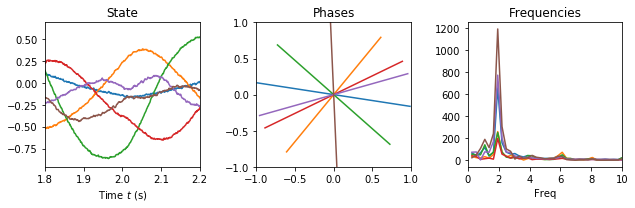

In [6]:
plot_delay_representation(*analyse_delay_representation(
        use_nengo_bio=False,));

Solved 200/200 neuron weights

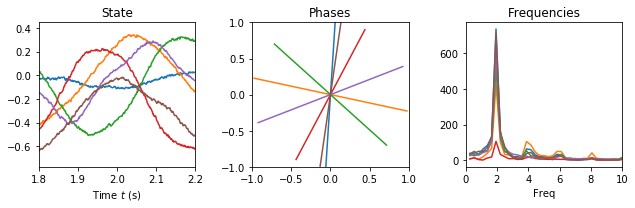

In [7]:
plot_delay_representation(*analyse_delay_representation(
                            use_nengo_bio=True,
                            solver_relax=False));

Solved 200/200 neuron weights

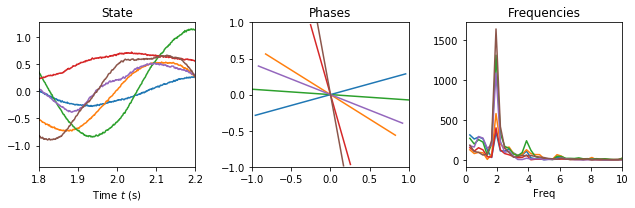

In [8]:
plot_delay_representation(*analyse_delay_representation(
                            use_nengo_bio=True,
                            solver_relax=True,));

In [26]:
def analyse_prediction_learnability(T=40.0, seed=34981, *args, **kwargs):
    np.random.seed(seed)
    model, _, probe_err = build_test_network(*args, **kwargs)
    with nengo.Simulator(model, progress_bar=None) as sim:
        sim.run(T)

        ts = sim.trange(probe_err.sample_every)
        ys = sim.data[probe_err][:, 0]
        h = np.exp(-np.square(ts - 0.5 * T) / np.square(0.4))
        h /= 0.4 * np.sum(h)

        it0 = np.min(np.where(ts > 1.0))
        it1 = np.max(np.where(ts < (T - 1.0)))

        ys_flt = np.convolve(np.abs(ys), h, 'same')[it0:it1]

        return ts[it0:it1], ys_flt / 0.6

In [35]:
# Repeat the learnability experiment for a few different seeds
yss = [[], [], []]
for i in range(50):
    seed = 5793 + i
    ts, ys1 = analyse_prediction_learnability(
            seed=seed,
            use_nengo_bio=False,)
    _, ys2 = analyse_prediction_learnability(
            seed=seed,
            solver_relax=False,
            use_nengo_bio=True,)
    _, ys3 = analyse_prediction_learnability(
            seed=seed,
            use_nengo_bio=True,
            solver_relax=True,)

    # Store the results in yss
    yss[0].append(ys1)
    yss[1].append(ys2)
    yss[2].append(ys3)

    sys.stderr.write("\nIteration {}\n".format(i + 1))

Solved 200/200 neuron weights
Iteration 1
Solved 200/200 neuron weights
Iteration 2
Solved 200/200 neuron weights
Iteration 3
Solved 200/200 neuron weights
Iteration 4
Solved 200/200 neuron weights
Iteration 5
Solved 200/200 neuron weights
Iteration 6
Solved 200/200 neuron weights
Iteration 7
Solved 200/200 neuron weights
Iteration 8
Solved 200/200 neuron weights
Iteration 9
Solved 200/200 neuron weights
Iteration 10
Solved 200/200 neuron weights
Iteration 11
Solved 200/200 neuron weights
Iteration 12
Solved 200/200 neuron weights
Iteration 13
Solved 200/200 neuron weights
Iteration 14
Solved 200/200 neuron weights
Iteration 15
Solved 200/200 neuron weights
Iteration 16
Solved 200/200 neuron weights
Iteration 17
Solved 200/200 neuron weights
Iteration 18
Solved 200/200 neuron weights
Iteration 19
Solved 200/200 neuron weights
Iteration 20
Solved 200/200 neuron weights
Iteration 21
Solved 200/200 neuron weights
Iteration 22
Solved 200/200 neuron weights
Iteration 23
Solved 200/200 neuro

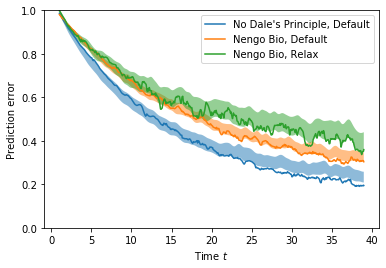

In [45]:
fig, ax = plt.subplots()
yss_arr = np.array(yss)
yss_mean = np.mean(yss_arr, axis=1)
yss_median = np.median(yss_arr, axis=1)
yss_stdd = np.sqrt(np.var(yss_arr, axis=1)) * 0.2
ax.plot(ts, yss_median[0], label='No Dale\'s Principle, Default')
ax.plot(ts, yss_median[1], label='Nengo Bio, Default')
ax.plot(ts, yss_median[2], label='Nengo Bio, Relax')

ax.fill_between(ts, yss_mean[0] - yss_stdd[0], yss_mean[0] + yss_stdd[0], alpha=0.5)
ax.fill_between(ts, yss_mean[1] - yss_stdd[1], yss_mean[1] + yss_stdd[1], alpha=0.5)
ax.fill_between(ts, yss_mean[2] - yss_stdd[2], yss_mean[2] + yss_stdd[2], alpha=0.5)

ax.set_xlabel('Time $t$')
ax.set_ylabel('Prediction error')
ax.set_ylim(0, 1)
ax.legend()

In [44]:
#np.save('learnability_experiment_2020_01_25_18_27.npz', yss_arr)

In [ ]:
# Open in GUI
model, _, _ = build_test_network(
    n_golgi=100,
    n_golgi_convergence=None,
    use_nengo_bio=True,
)
nengo_gui.jupyter.InlineGUI(model)